## Invoice classification with xgboost

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from xgboost import plot_tree

from collections import Counter
import pickle
import xgboost as xgb
import json
#from xgboost import cv

%matplotlib inline
print('Libraries Imported')

Libraries Imported


###  Loading the dataset

In [14]:
#helper function to load the dataset and separate features from response, and exclude certain columns
def load_dataset(filename, response_col):
    # load the dataset as a pandas DataFrame
    data =  pd.read_csv(filename ,sep = ',',decimal = ',', encoding = 'unicode_escape', engine ='python')
    #rename the response variable as 'response'
    data = data.rename(columns={response_col:'response'})
    return data

In [15]:
data = load_dataset('Scripts/dataset_32_pendigits.csv', 'class')
data.head()

,input1,input2,input3,input4,input5,input6,input7,input8,input9,input10,input11,input12,input13,input14,input15,input16,response
0,47,100,27,81,57,37,26,0,0,23,56,53,100,90,40,98,8
1,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6,2
2,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0,1
3,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0,4
4,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0,1


### Counting the number of samples in each class after removing the classes with less than 20 samples

In [16]:
#Number of samples in each class
Counter(data['response'].values)

Counter({8: 1055,
         2: 1144,
         1: 1143,
         4: 1144,
         6: 1056,
         0: 1143,
         5: 1055,
         9: 1055,
         7: 1142,
         3: 1055})

In [17]:
# split into input (X) and output (y) variables
X = data[data.columns.difference(['response'])]
y = data.response

#### Distribution of the classes is balanced

<AxesSubplot:ylabel='response'>

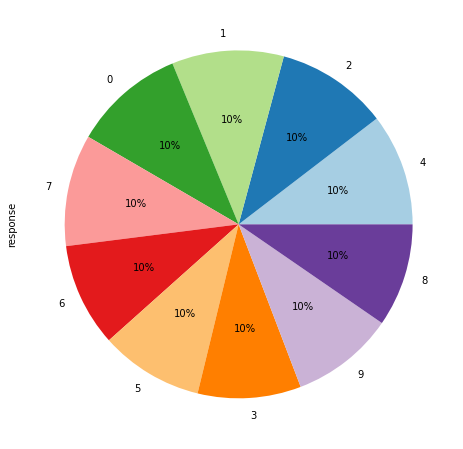

In [18]:
#distrib of the response variable
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
data.response.value_counts().plot(kind='pie', autopct='%1.0f%%', colors= sns.color_palette("Paired"))

### Here The training and validation was split 75-25, then, 2%(54 samples) from the validation set were saved as testing data, to test the model and also use it in the api.

In [19]:
#split into train, test
X_train, X_test, y_train, y_test = train_test_split(X, integers, test_size=0.25, random_state=2)

# Split train into test-val for early training stopping and for checking with small sample of new data
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.98, stratify=y_test, random_state=2587)

In [20]:
y_train =  np.array(y_train, dtype = 'int64')
y_val = np.array(y_val, dtype = 'int64')
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(8244, 16) (54, 16) (2694, 16) (8244,) (54,) (2694,)


### Defining model parameters (not ideal but good enough)

In [17]:
#params were chosen experimentally after performing a few tests on a 
#subset of 1000 samples. (may not be the best params)

params = { 'eta' : 0.1,#eta between(0.01-0.2)
            'max_depth' : 4, #values between(3-10)
            'max_delta_step' : 0.5,
            'subsample' : 0.7,#values between(0.5-1)
            'colsample_bytree' : 0.5,#values between(0.5-1)
            'tree_method' : "auto",
            'alpha': 0.2,
            'lambda' : 1,
            'process_type' : "default",
            'num_parallel_tree': 1,
            'objective': 'multi:softmax',
            'min_child_weight' : 1,
            'booster': 'gbtree',
            'sample_type' : "uniform",
            'eval_metric' : "merror",
            'num_class' : 63}


### Training the model using the validation set for early stopping (NOT cross validation)

In [18]:
#Xgb
from xgboost import XGBClassifier
model=XGBClassifier(params,use_label_encoder=False)
model.fit(X_train,y_train, eval_set = [(X_val, y_val)], verbose = True, early_stopping_rounds=10, eval_metric='merror')

[0]	validation_0-merror:0.06051
[1]	validation_0-merror:0.04157
[2]	validation_0-merror:0.03266
[3]	validation_0-merror:0.02858
[4]	validation_0-merror:0.02338
[5]	validation_0-merror:0.02153


C:\Users\ostoices\anaconda3\lib\site-packages\xgboost\core.py:416: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[6]	validation_0-merror:0.01930
[7]	validation_0-merror:0.01745
[8]	validation_0-merror:0.01670
[9]	validation_0-merror:0.01522
[10]	validation_0-merror:0.01485
[11]	validation_0-merror:0.01336
[12]	validation_0-merror:0.01262
[13]	validation_0-merror:0.01188
[14]	validation_0-merror:0.01039
[15]	validation_0-merror:0.00965
[16]	validation_0-merror:0.00965
[17]	validation_0-merror:0.01002
[18]	validation_0-merror:0.01002
[19]	validation_0-merror:0.00965
[20]	validation_0-merror:0.00928
[21]	validation_0-merror:0.00928
[22]	validation_0-merror:0.00928
[23]	validation_0-merror:0.00928
[24]	validation_0-merror:0.00928
[25]	validation_0-merror:0.01002
[26]	validation_0-merror:0.00928
[27]	validation_0-merror:0.00817
[28]	validation_0-merror:0.00854
[29]	validation_0-merror:0.00817
[30]	validation_0-merror:0.00854
[31]	validation_0-merror:0.00817
[32]	validation_0-merror:0.00779
[33]	validation_0-merror:0.00742
[34]	validation_0-merror:0.00742
[35]	validation_0-merror:0.00779
[36]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

#### Accuracy on the training set

In [19]:
xgb_pred_train = model.predict(X_train)
print(metrics.accuracy_score(y_train, xgb_pred_train)*100)

100.0


#### Accuracy on the validation set

In [20]:
xgb_pred_val = model.predict(X_val)
print(metrics.accuracy_score(y_val, xgb_pred_val)*100)

99.25760950259837


### Confusion matrix on the validation set

<AxesSubplot:>

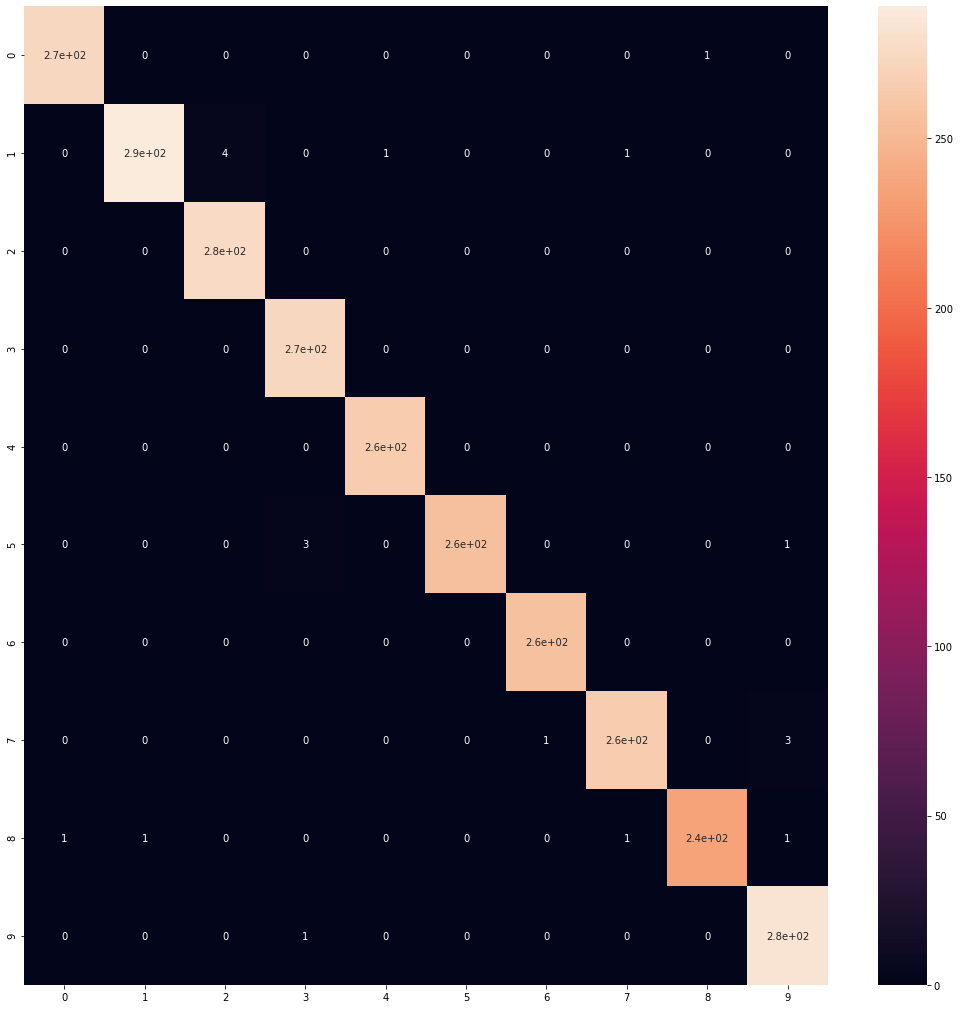

In [21]:
plt.rcParams["figure.figsize"] = (2^16, 2^16)
#confusion matrix
confusion_matrix_xgb = pd.DataFrame(confusion_matrix(y_val, xgb_pred_val))

sns.heatmap(confusion_matrix_xgb, annot=True)

#### A small sample of the model's output vs true labels

In [22]:
print (xgb_pred_val [0:10])
print (y_val [0:10])

[7 2 3 8 0 6 5 7 0 1]
[7 1 3 8 0 6 5 7 0 1]


### Detailed performance measures on the validation set

In [23]:
print(classification_report(y_val, xgb_pred_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       275
           1       1.00      0.98      0.99       295
           2       0.99      1.00      0.99       276
           3       0.99      1.00      0.99       274
           4       1.00      1.00      1.00       265
           5       1.00      0.98      0.99       260
           6       1.00      1.00      1.00       257
           7       0.99      0.99      0.99       269
           8       1.00      0.98      0.99       239
           9       0.98      1.00      0.99       284

    accuracy                           0.99      2694
   macro avg       0.99      0.99      0.99      2694
weighted avg       0.99      0.99      0.99      2694



## Test the model on new data

#### Make predictions on the test set

In [24]:
#test on new data
xgb_pred_test = model.predict(X_test)
print(metrics.accuracy_score(y_test, xgb_pred_test)*100)

100.0


#### View predicted labels vs real labels

In [29]:
#check first 10 predicted vs test
print("Predicted Labels")
print (xgb_pred_test[0:10])
y_test = np.array(y_test)
print("Real Labels")
print (y_test[0:10])

Predicted Labels
[6 2 2 0 8 8 7 7 7 5]
Real Labels
[6 2 2 0 8 8 7 7 7 5]


### Test set confusion matrix

<AxesSubplot:>

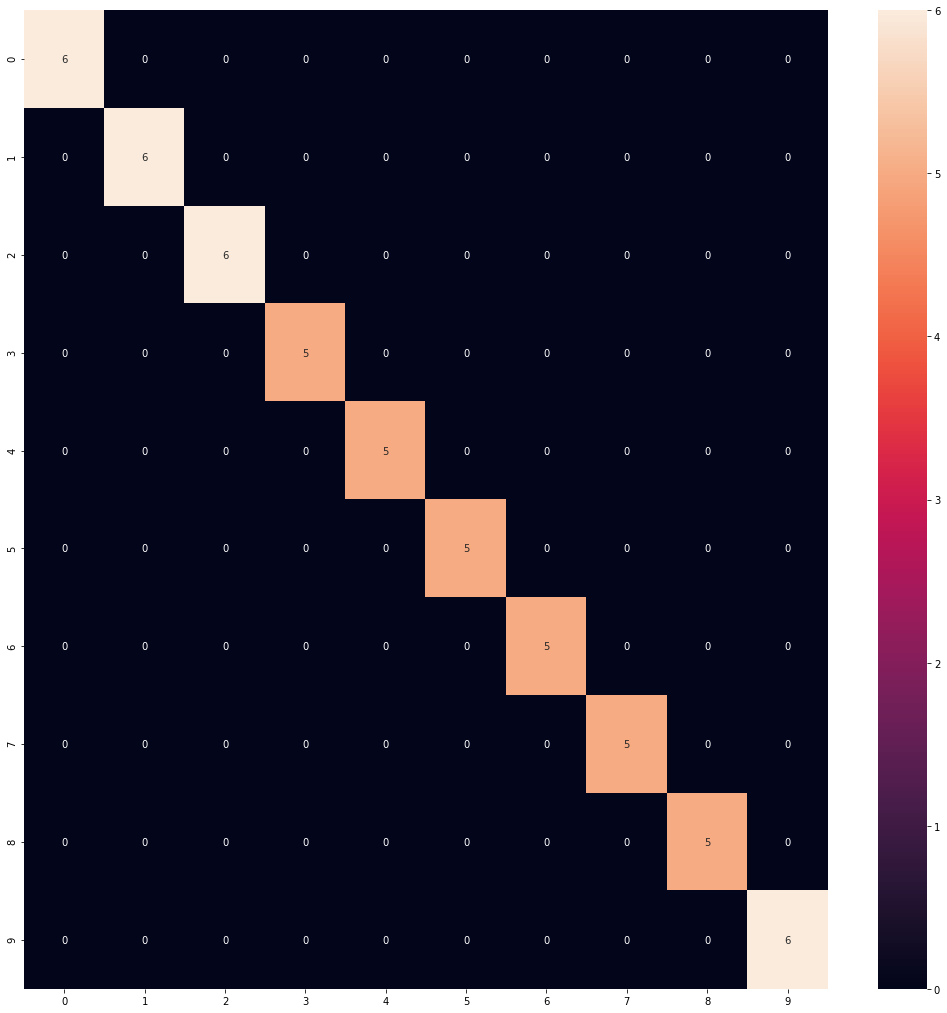

In [30]:
plt.rcParams["figure.figsize"] = (2^16, 2^16)
#confusion matrix
confusion_matrix_xgb = pd.DataFrame(confusion_matrix(y_test, xgb_pred_test))

sns.heatmap(confusion_matrix_xgb, annot=True)

In [22]:
for jdict in X_test.to_dict(orient='records'):
    print(jdict)

{'input1': 100, 'input10': 7, 'input11': 80, 'input12': 0, 'input13': 80, 'input14': 24, 'input15': 26, 'input16': 26, 'input2': 100, 'input3': 46, 'input4': 89, 'input5': 13, 'input6': 64, 'input7': 0, 'input8': 34, 'input9': 25}
{'input1': 0, 'input10': 1, 'input11': 1, 'input12': 0, 'input13': 51, 'input14': 15, 'input15': 100, 'input16': 0, 'input2': 86, 'input3': 39, 'input4': 100, 'input5': 51, 'input6': 66, 'input7': 35, 'input8': 32, 'input9': 8}
{'input1': 36, 'input10': 20, 'input11': 12, 'input12': 8, 'input13': 56, 'input14': 6, 'input15': 100, 'input16': 0, 'input2': 100, 'input3': 60, 'input4': 100, 'input5': 57, 'input6': 68, 'input7': 33, 'input8': 41, 'input9': 0}
{'input1': 43, 'input10': 22, 'input11': 100, 'input12': 67, 'input13': 68, 'input14': 100, 'input15': 21, 'input16': 97, 'input2': 91, 'input3': 9, 'input4': 59, 'input5': 0, 'input6': 14, 'input7': 43, 'input8': 0, 'input9': 85}
{'input1': 0, 'input10': 34, 'input11': 68, 'input12': 67, 'input13': 100, 'inp

In [25]:
y_test

8244     6
5880     2
6953     2
5583     0
10768    8
10698    8
2998     7
6899     7
3625     7
2394     5
120      8
7447     1
4454     0
10811    0
6048     4
2325     0
6630     4
10704    6
9453     3
1351     4
9003     4
10667    1
2965     9
1797     9
4706     2
3408     7
4773     9
1525     8
6498     6
3144     9
5953     3
7417     6
3992     5
7450     2
4510     9
1591     8
454      1
3333     2
6742     1
9321     2
831      5
6367     4
249      1
9196     0
8346     3
2125     0
9581     7
2861     9
10612    5
10122    3
8858     1
1583     3
7318     5
6715     6
dtype: int8